SNR (dB)    ACCURACY  

0           0.54250   
1           0.61500   
2           0.59250   
3           0.61250   
4           0.67250   
5           0.69250   
6           0.75750   
7           0.82250   
8           0.88750   
9           0.88500   
10          0.92000   
11          0.96750   
12          0.97000   
13          0.98750   
14          0.99500   
15          0.99750   
16          1.00000   
17          1.00000   
18          1.00000   
19          1.00000   
20          1.00000   

Accuracy: 84.86%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.84      0.85      4200
         1.0       0.85      0.85      0.85      4200

    accuracy                           0.85      8400
   macro avg       0.85      0.85      0.85      8400
weighted avg       0.85      0.85      0.85      8400



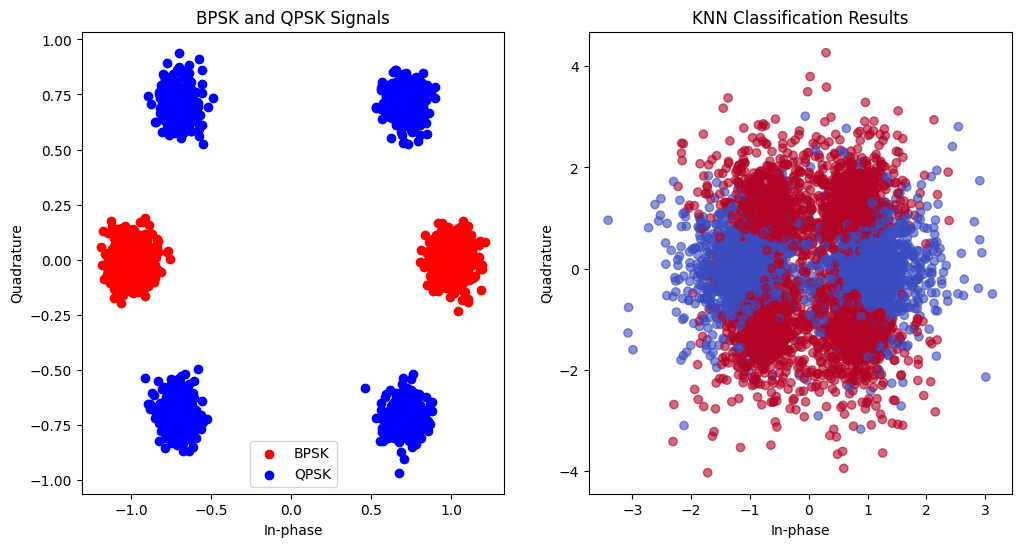

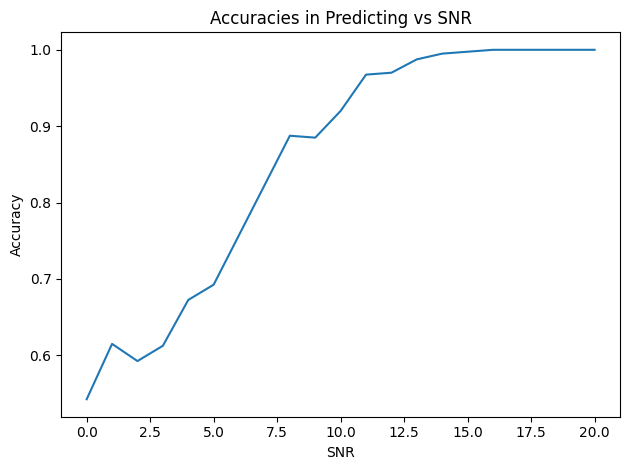

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

def generate_bpsk_signal(num_samples, SNR_dB):
    bits = np.random.randint(0, 2, num_samples)
    symbols = 2 * bits - 1
    noise = (1/np.sqrt(2)) * (np.random.randn(num_samples) + 1j * np.random.randn(num_samples))
    SNR_linear = 10**(SNR_dB / 10.0)
    noise_power = np.var(symbols) / SNR_linear
    noisy_symbols = symbols + np.sqrt(noise_power) * noise
    return noisy_symbols

def generate_qpsk_signal(num_samples, SNR_dB):
    bits = np.random.randint(0, 4, num_samples)
    symbols = np.exp(1j * (np.pi / 4 + np.pi / 2 * bits))
    noise = (1/np.sqrt(2)) * (np.random.randn(num_samples) + 1j * np.random.randn(num_samples))
    SNR_linear = 10**(SNR_dB / 10.0)
    noise_power = np.var(symbols) / SNR_linear
    noisy_symbols = symbols + np.sqrt(noise_power) * noise
    return noisy_symbols

def extract_features(signal):
    features = np.vstack((np.real(signal), np.imag(signal))).T
    return features

X_train=[]
Y_train=[]
X_test=[]
Y_test=[]

accuracies=[]
SNRs=[]

print(f"{'SNR (dB)':<12}{'ACCURACY':<10}\n")
for i in range(0,21):
  num_samples = 1000
  SNR_dB = i

  SNRs.append(i)
  bpsk_signal = generate_bpsk_signal(num_samples, SNR_dB)
  qpsk_signal = generate_qpsk_signal(num_samples, SNR_dB)

  bpsk_features = extract_features(bpsk_signal)
  qpsk_features = extract_features(qpsk_signal)

  bpsk_labels = np.zeros(num_samples)
  qpsk_labels = np.ones(num_samples)

  split_val=int(0.8*num_samples)

  X_train.append(bpsk_features[:split_val])
  X_train.append(qpsk_features[:split_val])

  Y_train.append(bpsk_labels[:split_val])
  Y_train.append(qpsk_labels[:split_val])

  X_test.append(bpsk_features[split_val:])
  X_test.append(qpsk_features[split_val:])

  Y_test.append(bpsk_labels[split_val:])
  Y_test.append(qpsk_labels[split_val:])

  X_temp = np.vstack((bpsk_features, qpsk_features))
  Y_temp = np.hstack((bpsk_labels, qpsk_labels))

  X_tr, X_te, y_tr, y_te = train_test_split(X_temp, Y_temp, test_size=0.2, random_state=42)


  scaler = StandardScaler()
  X_tr = scaler.fit_transform(X_tr)
  X_te = scaler.transform(X_te)

  k = 3
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_tr, y_tr)


  y_pr = knn.predict(X_te)
  acc = accuracy_score(y_te, y_pr)
  print(f"{SNR_dB:<12}{acc:<10.5f}")
  accuracies.append(acc)


X_train=np.vstack(X_train)
Y_train=np.hstack(Y_train)

X_test=np.vstack(X_test)
Y_test=np.hstack(Y_test)

shuffle_index_train=np.random.permutation(len(X_train))

X_train=X_train[shuffle_index_train]
Y_train=Y_train[shuffle_index_train]

shuffle_index_test=np.random.permutation(len(X_test))

X_test=X_test[shuffle_index_test]
Y_test=Y_test[shuffle_index_test]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, Y_train)

y_pred = knn.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)

print(f"\nAccuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(bpsk_features[:, 0], bpsk_features[:, 1], color='r', label='BPSK')
plt.scatter(qpsk_features[:, 0], qpsk_features[:, 1], color='b', label='QPSK')
plt.title("BPSK and QPSK Signals")
plt.xlabel("In-phase")
plt.ylabel("Quadrature")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='coolwarm', alpha=0.6)
plt.title("KNN Classification Results")
plt.xlabel("In-phase")
plt.ylabel("Quadrature")

plt.figure()
plt.plot(SNRs,accuracies)
plt.title("Accuracies in Predicting vs SNR")
plt.xlabel("SNR")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()